# Redes Neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  auc, plot_roc_curve
from numpy.random import seed
seed(42)

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

from tensorflow.keras import models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import tensorflow.keras as keras

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [5]:
from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesRedes
from preprocessing import ingenieriaDeFeaturesRedes2

In [6]:
def entrenarRedNeuronal(modelo, epochs, tamanio):
    historia = modelo.fit(X_train, y_train, batch_size=tamanio, epochs=epochs, verbose=0, 
                          validation_data=(X_test, y_test))
    return historia, modelo
    

In [7]:
def graficaDePerdida(historia):
    plt.figure(dpi=100, figsize=(20, 10))
    plt.plot(historia.history['loss'][4:])
    plt.plot(historia.history['val_loss'][4:])
    plt.title('Perdida del modelo')
    plt.ylabel('Perdida')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [8]:
def graficaDeRocCurve(modelo, nombre_modelo):
    false_positive_rate_test, recall_test, thresholds_test = roc_curve(y_test, modelo.predict_proba(X_test))
    false_positive_rate_train, recall_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train)) 
    roc_auc = auc(false_positive_rate_test, recall_test)
    roc_auc2 = auc(false_positive_rate_train, recall_train)

    plt.plot(false_positive_rate_test, recall_test, 'b', label = 'val = %0.3f' %roc_auc)
    plt.plot(false_positive_rate_train, recall_train, 'r', label = 'train = %0.3f' %roc_auc2)
    plt.legend(loc='lower right')
    plt.title("Curva roc del modelo: " + nombre_modelo)
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show()

## Carga y procesamientos de datos 

In [9]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)

In [10]:
train2_df = train_df.copy()

realizamos el preprocesamiento correspondiente a este modelo. En este caso vamos a aplicar one hot encoding y normalizar las variables correspondientes.

In [11]:
X,y,df,y_encoder = ingenieriaDeFeaturesRedes(train_df)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

In [13]:
X2,y2,df2,y_encoder2, meanEncoding = ingenieriaDeFeaturesRedes2(train2_df)

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=117, test_size=0.1, stratify=y2)

Los hiperparametros a tener en cuenta son:
   * learning rate
   * optimizador
   * funcion de costo
   * la funcion de activacion
   * cantidad de capaz y cantidad de neuronas por capa 
   * regularizaciones


Arracamos entrenenado una red simple sin regularizaciones

# Red 1

Vamos a utilizar como funcion de costo la de binary crossentropy y el optimizador SDG

In [15]:
red1 = Sequential()
red1.add(Dense(31, input_dim=31, kernel_initializer='normal', activation='relu'))
red1.add(Dense(10, activation='tanh'))
red1.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.SGD(learning_rate=0.3)
red1.compile(loss='binary_crossentropy', optimizer=opt)

Vemos el resumen de la red 

In [16]:
red1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 31)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,323
Trainable params: 1,323
Non-trainable params: 0
_________________________________________________________________


In [17]:
historia, red1 =  entrenarRedNeuronal(red1, 100, 10)

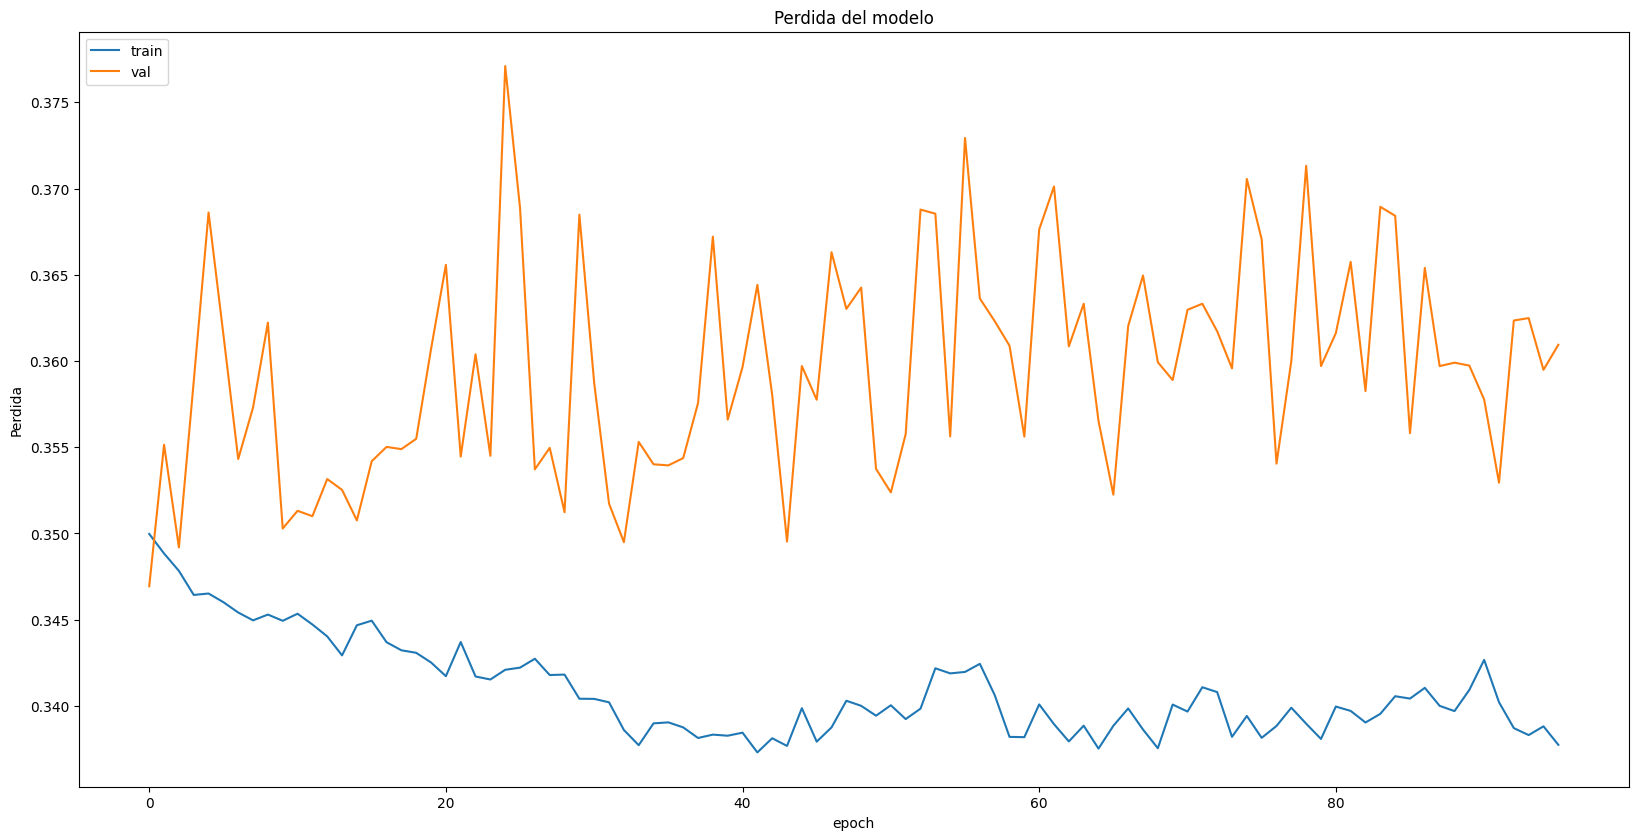

In [18]:
graficaDePerdida(historia)

obsevamos las metricas

In [19]:
y_pred = red1.predict(X_test)
y_pred = np.around(y_pred, decimals=0)

In [20]:
print(classification_report(y_test, y_pred, target_names=['No tiene alto valor adquisitivo','Tiene alto valor adquisitivo']))

                                 precision    recall  f1-score   support

No tiene alto valor adquisitivo       0.87      0.93      0.90      2473
   Tiene alto valor adquisitivo       0.72      0.55      0.63       784

                       accuracy                           0.84      3257
                      macro avg       0.79      0.74      0.76      3257
                   weighted avg       0.83      0.84      0.83      3257



/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


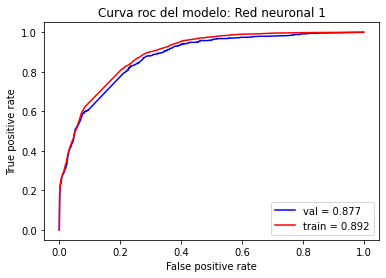

In [21]:
graficaDeRocCurve(red1, "Red neuronal 1")

vemos que el error de validacion es bastante alto, entonces vamos a probar bajando el learning rate y aumentando los epochs

# Red 2

In [22]:
red2 = Sequential()
red2.add(Dense(31, input_dim=31, activation='relu'))
red2.add(Dense(14, activation='tanh'))
red2.add(Dense(1, activation='sigmoid'))
opt2 = keras.optimizers.SGD(learning_rate=0.001) 
red2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=[tf.keras.metrics.AUC()])

In [23]:
historia, red2 =  entrenarRedNeuronal(red2, 500, 50) 

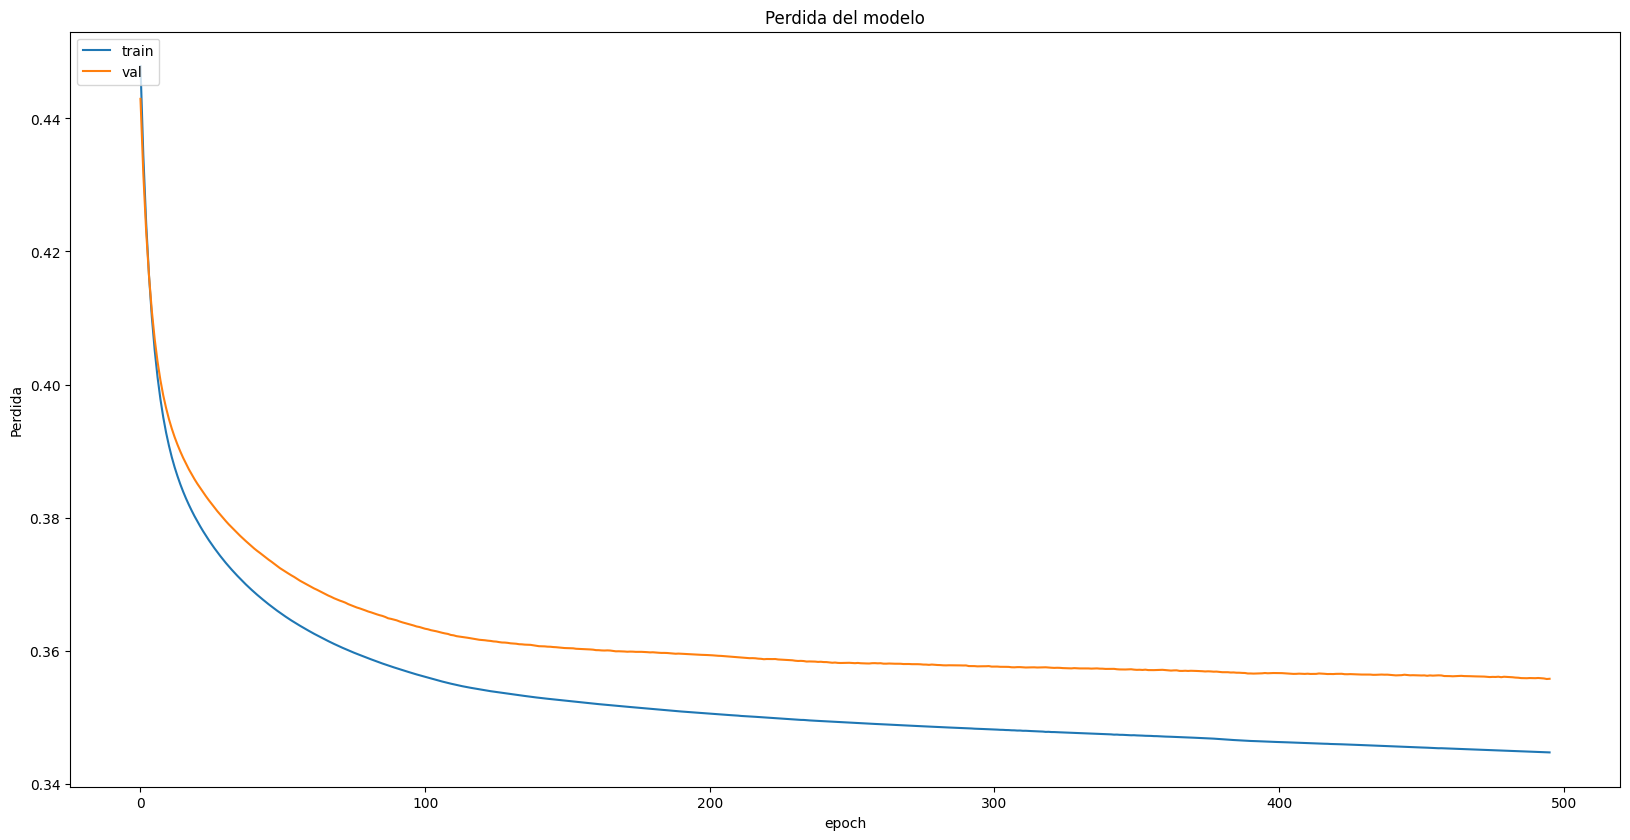

In [24]:
graficaDePerdida(historia)

/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


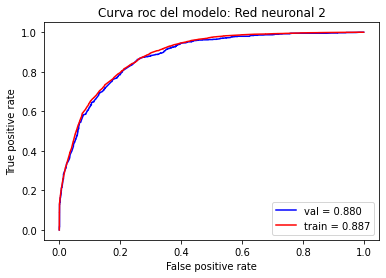

In [25]:
graficaDeRocCurve(red2, "Red neuronal 2")

Podemos ver que el error no es tan notorio sino que las curvas de tarin y validation son bastante proximas. Vamos a buscar juntarlas mas en una tercera red. Vamos a agregar un dropout para ver si mejora la prediccion.

# Red 3 

In [26]:
red3 = Sequential()
red3.add(Dense(31, input_dim=31, activation='relu'))
red3.add(Dropout(0.5))
red3.add(Dense(14, activation='tanh'))
red3.add(Dense(1, activation='sigmoid'))
opt3 = keras.optimizers.Adam(learning_rate=0.0001)
red3.compile(loss='binary_crossentropy', optimizer=opt3, metrics=[tf.keras.metrics.AUC()])

In [27]:
historia3, red3 =  entrenarRedNeuronal(red3, 500, 50)

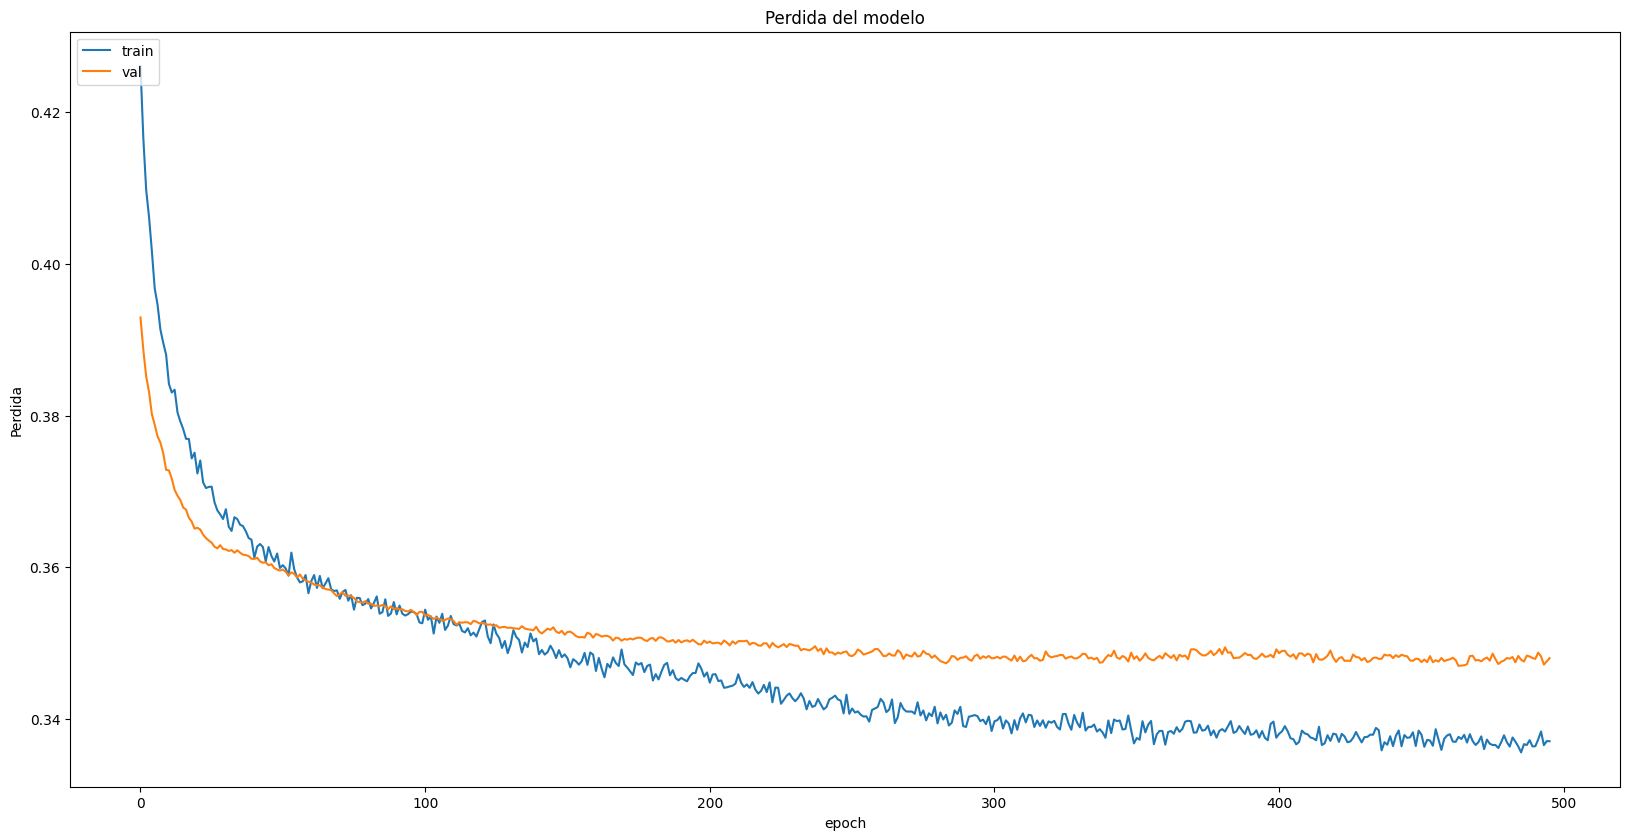

In [28]:
graficaDePerdida(historia3)

/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


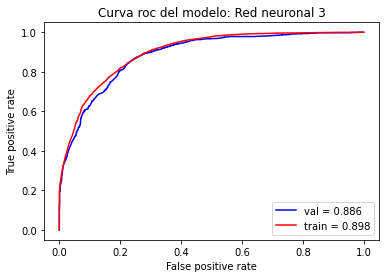

In [29]:
graficaDeRocCurve(red3, "Red neuronal 3")

 vemos que el score de validation mejora un poco, probamos agregandole regularizacion l1 y l2

# Red 4

In [30]:
red4 = Sequential()
red4.add(Dense(31, input_dim=31, activation='relu'))
red4.add(Dropout(0.3))
red4.add(Dense(14, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(0.001), 
                                       activity_regularizer=tf.keras.regularizers.l2(0.01)))
red4.add(Dense(1, activation='sigmoid'))
opt4 = keras.optimizers.Adam(learning_rate=0.0001)
red4.compile(loss='binary_crossentropy', optimizer=opt4, metrics=[tf.keras.metrics.AUC()])

In [31]:
historia4, red4 =  entrenarRedNeuronal(red4, 350, 50)

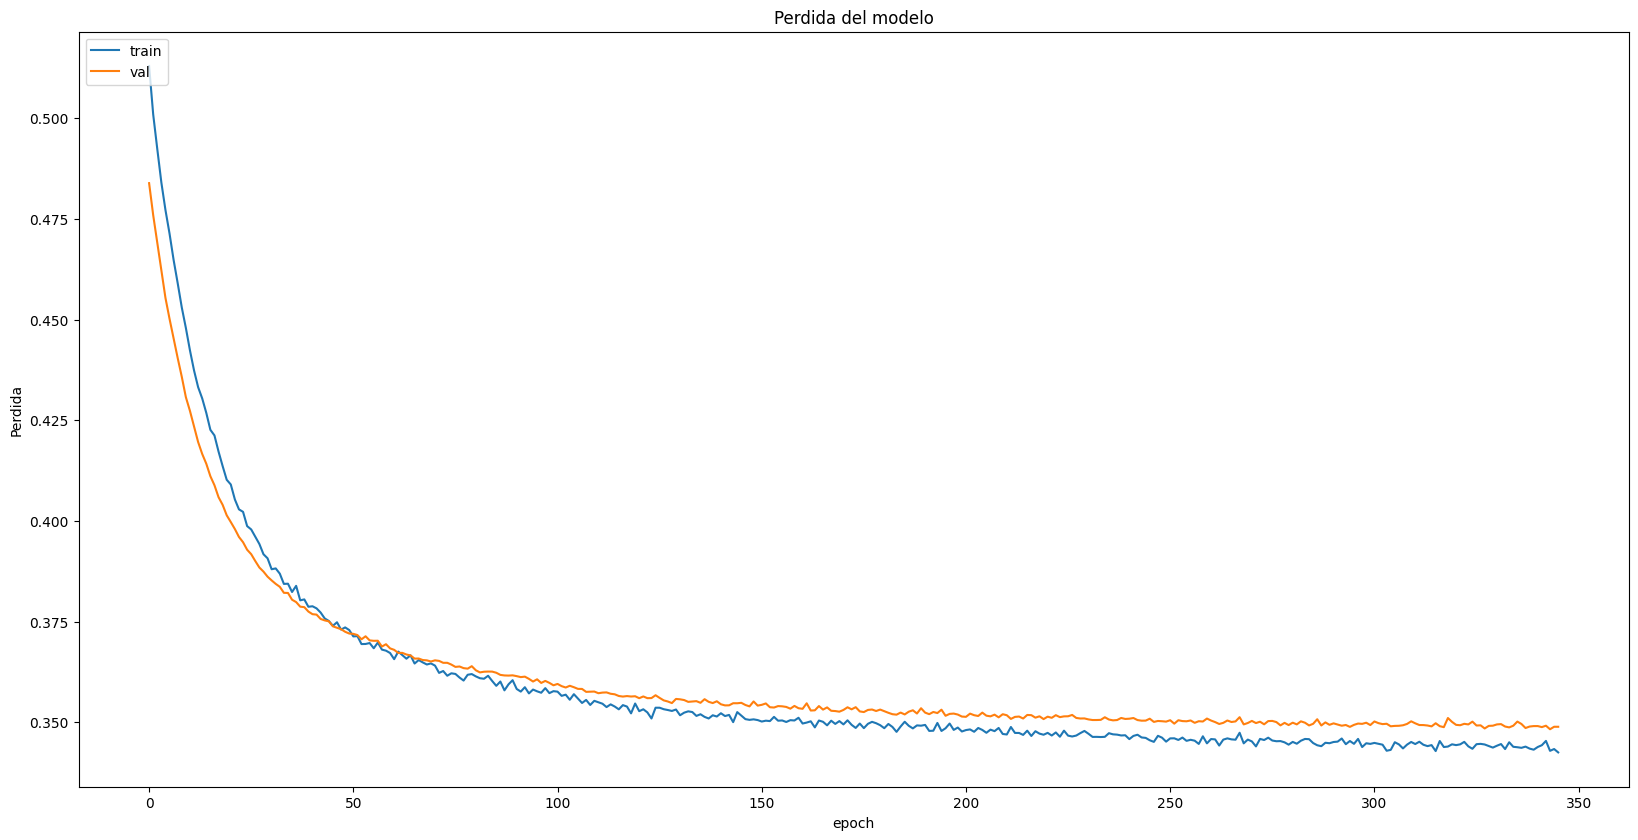

In [32]:
graficaDePerdida(historia4)

le aplicamos el segundo preprosesamiento

In [33]:
red5 = Sequential()
red5.add(Dense(10, input_dim=6, activation='relu'))
red5.add(Dropout(0.3))
red5.add(Dense(5, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(0.001), 
                                       activity_regularizer=tf.keras.regularizers.l2(0.01)))
red5.add(Dense(1, activation='sigmoid'))
opt5 = keras.optimizers.Adam(learning_rate=0.0001)
red5.compile(loss='binary_crossentropy', optimizer=opt5, metrics=[tf.keras.metrics.AUC()])

In [34]:
historia5 = red5.fit(X_train2, y_train2, batch_size=50, epochs=350, verbose=0, 
                          validation_data=(X_test2, y_test2))

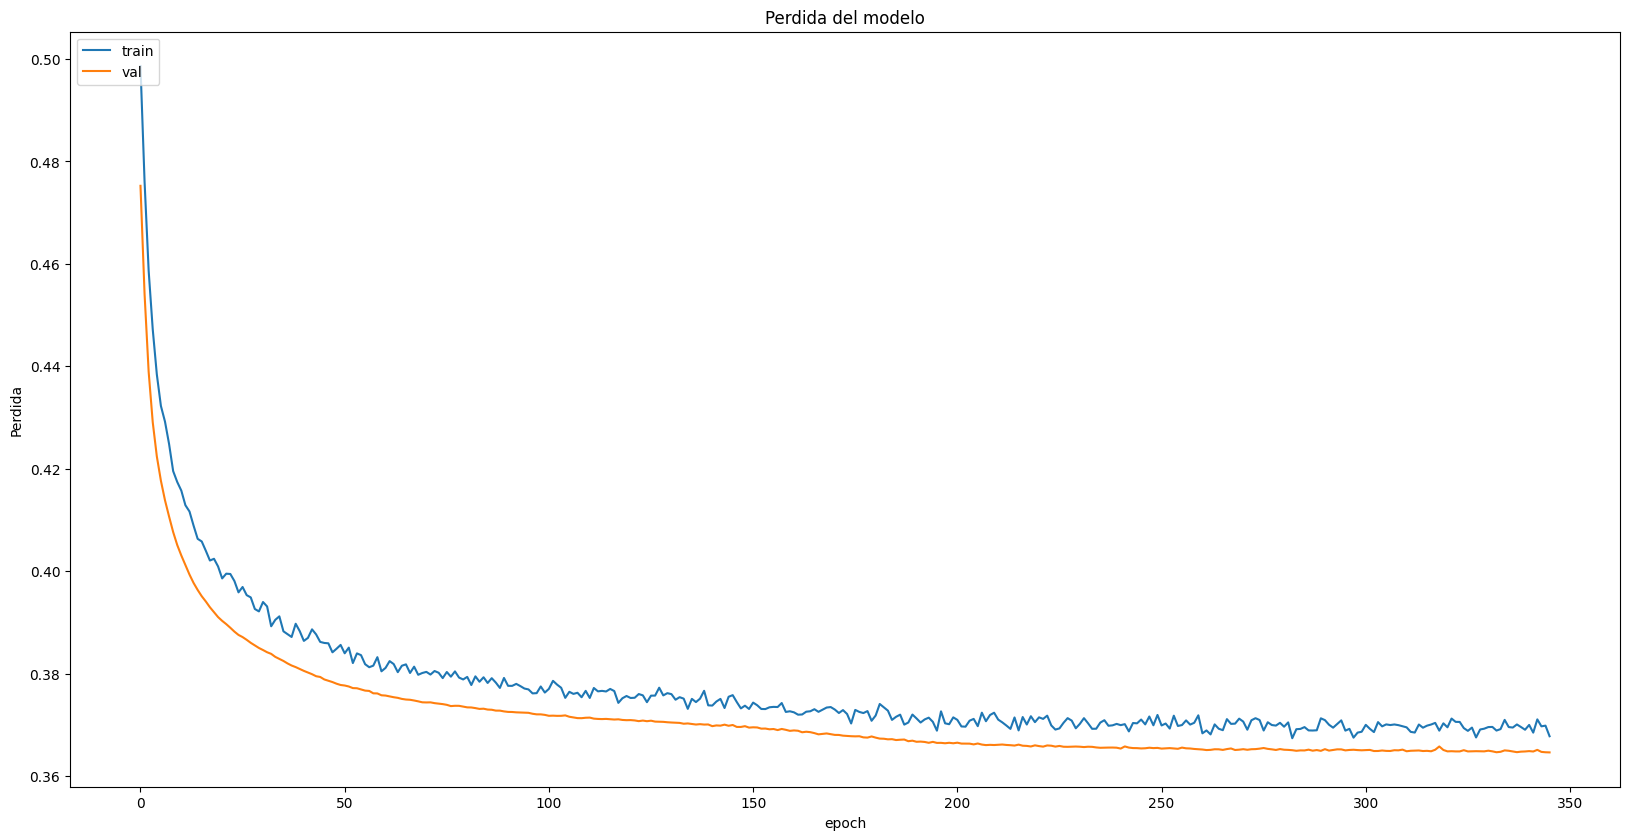

In [35]:
graficaDePerdida(historia5)

podemos ver que dioern bastante similar ambos proesamientos pero la red 4 dio un mejor resultado. Evaluamos las metricas 
con el primer preprosesamiento. 

# Metricas

/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


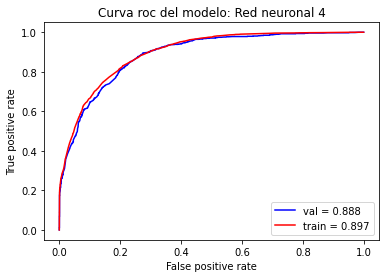

In [36]:
graficaDeRocCurve(red4, "Red neuronal 4")

In [37]:
y_pred = red4.predict(X_test)
y_pred = np.around(y_pred, decimals=0)

In [38]:
print(classification_report(y_test, y_pred, target_names=['No tiene alto valor adquisitivo','Tiene alto valor adquisitivo']))

                                 precision    recall  f1-score   support

No tiene alto valor adquisitivo       0.87      0.93      0.90      2473
   Tiene alto valor adquisitivo       0.72      0.57      0.64       784

                       accuracy                           0.84      3257
                      macro avg       0.80      0.75      0.77      3257
                   weighted avg       0.84      0.84      0.84      3257



# auc roc

In [39]:
auc_red = roc_auc_score(y_test,red4.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

/home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC para redes neuronales: 0.888


## Prediccion sobre el data set de hold out

In [42]:
from preprocessing import prepararSetDeHoldOutRedes

In [43]:
final_df = prepararSet(final_df)
final_df['categoria_de_trabajo_empleadao_estatal'] = 0
final_df['trabajo_directivo_gerente'] = 0

In [44]:
final_df = prepararSetDeHoldOutRedes(final_df)

ho_prediction = red4.predict(final_df)
final_df['tiene_alto_valor_adquisitivo'] = ho_prediction

final_df.to_csv('predicciones/redes_neuronales.csv')

ValueError: in user code:

    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/sol/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 31 but received input with shape (None, 33)
